<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

Lightweight On-line Detector of Anomalies with MinMaxScaler

This code template is for Anomaly detection using the Lightweight On-line Detector(LODA) Algorithm implemented using the pyod library. The implementation utilizes a data engineering technique named data rescaling using MinMaxScaler to scale down data.

### Required Packages

In [ ]:
!pip install plotly
!pip install pyod

In [2]:
import time
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from pyod.models.loda import LODA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

### Initialization

Filepath of CSV file

In [3]:
file_path= ''

List of features which are  required for model training 

In [4]:
features = []

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [5]:
df=pd.read_csv(file_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X.

In [6]:
X=df[features]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.

In [7]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

Calling preprocessing functions on the feature set.

In [8]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])  
X=EncodeX(X)
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


### Data Rescaling

`MinMaxScaler` subtracts the minimum value in the feature and then divides by the range, where range is the difference between the original maximum and original minimum.

[For more Reference](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [9]:
X_Scaled=MinMaxScaler().fit_transform(X)
X_Scaled=pd.DataFrame(data = X_Scaled,columns = X.columns)
X_Scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.000000,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,...,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824
1,0.000000,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,...,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105
2,0.000006,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,...,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739
3,0.000006,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,...,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807
4,0.000012,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,...,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724


### Data Splitting

The train-test split is a procedure for evaluating the performance of an algorithm. The procedure involves taking a dataset and dividing it into two subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [10]:
x_train,x_test=train_test_split(X_Scaled,test_size=0.2,random_state=123)

### Model

Loda: Lightweight on-line detector of anomalies Adapted from tilitools

#### Tuning parameters

**contamination**  – The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the decision function.

**n_bins**  – The number of bins for the histogram.

**n_random_cuts**  – The number of random cuts.

[For more information](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.loda)

In [11]:
model = LODA(contamination=0.001)
model.fit(x_train)

LODA(contamination=0.001, n_bins=10, n_random_cuts=100)

### Anomaly Prediction

In [12]:
result=x_test.copy(deep=True)
result['Anomaly']=model.predict(x_test)
result.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Anomaly
73129,0.318255,0.947706,0.778843,0.850389,0.285771,0.764508,0.260417,0.267976,0.790393,0.430539,...,0.565399,0.531883,0.664615,0.380579,0.564631,0.371899,0.416941,0.314938,0.001946,0
229597,0.844848,0.994917,0.756726,0.817330,0.207942,0.762454,0.259914,0.261231,0.783310,0.459920,...,0.564297,0.534243,0.665485,0.245064,0.577375,0.406102,0.416394,0.312041,0.002258,0
220218,0.822220,0.985729,0.765201,0.801883,0.317078,0.769354,0.256329,0.269484,0.782746,0.460026,...,0.561011,0.492787,0.664375,0.312041,0.583034,0.303078,0.416083,0.313052,0.007707,0
198374,0.766598,0.990721,0.740696,0.842220,0.186919,0.755471,0.293242,0.248293,0.795913,0.474821,...,0.562300,0.555960,0.667869,0.260187,0.549188,0.441374,0.419235,0.312382,0.003192,0
167980,0.688695,0.994324,0.756198,0.804559,0.197137,0.765456,0.260257,0.262986,0.783273,0.440422,...,0.568830,0.562558,0.661518,0.203992,0.595223,0.447115,0.415457,0.311605,0.003649,0


### Anomaly Visualization

#### Bar Plot

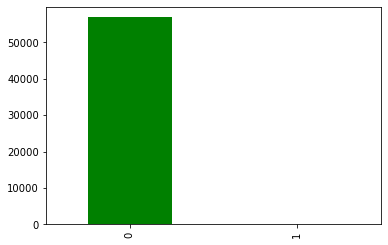

In [13]:
result['Anomaly'].value_counts().plot(kind='bar',color=['green','red'])

#### Pie Chart

In [14]:
fig = px.pie(result['Anomaly'],names=result['Anomaly'], title='Anomaly rate',)
fig.show()

#### Anomalies

In this part we will perform Dimensionality Reduction technique to visualize data. This can be performed using technique such as PCA or TSNE algorithms.

In [15]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(result.drop('Anomaly',axis=1))

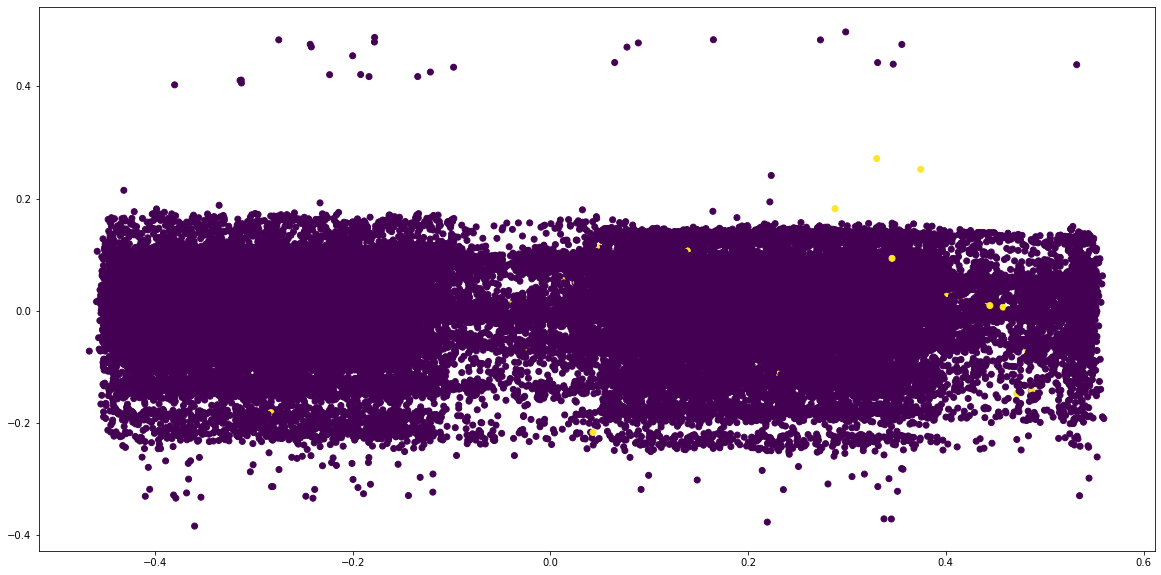

In [16]:
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(x=pca_results[:,0],y=pca_results[:,1],c=result.iloc[:,result.columns.get_loc('Anomaly')])
plt.show()

#### Creator: Vamsi Mukkamala , Github: [Profile](https://github.com/vmc99)